### Multiclass Logistic Regression


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()


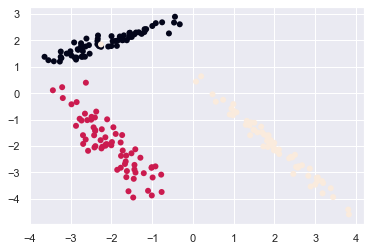

In [3]:
# one-vs-all
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=200, n_features=2, n_classes=3, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1, class_sep=2.0, random_state=101)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, linewidths=0, edgecolors=None)
plt.show()


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [5]:
# predict one variable & look at results (PROBABILITIES)
print(X_test[0])
print(y_test[0])
print(y_pred[0])

print(clf.predict_proba(X_test[0].reshape(1, -1)))

[-3.26744968  1.19639333]
0
0
[[0.85566647 0.13526263 0.0090709 ]]


In [6]:
# hardcore version w/ statsmodels

X, y = make_classification(n_samples=10000, n_features=10, n_informative=10, n_redundant=0, random_state=101)

In [7]:
import statsmodels.api as sm

Xc = sm.add_constant(X)
logistic_regression = sm.Logit(y, Xc)
fitted_model = logistic_regression.fit()


Optimization terminated successfully.
         Current function value: 0.438685
         Iterations 7


In [8]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9989
Method:                           MLE   Df Model:                           10
Date:                Sun, 21 Mar 2021   Pseudo R-squ.:                  0.3671
Time:                        17:32:11   Log-Likelihood:                -4386.8
converged:                       True   LL-Null:                       -6931.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4299      0.039     11.023      0.000       0.353       0.506
x1             0.0671      0.015      4.410      0.000       0.037       0.097
x2            -0.7828      0.019    -41.947      0.000      -0.819      -0.746
x3             0.1221      0.016      7.815      0.000       0.091       0.153
x4             0.2841      0.016     18.150      0.000       0.253       0.315
x5             0.1469      0.014     10.283      0.000       0.119       0.175
x6            -0.3414      0.019    -17.636      0.000      -0.379      -0.303
x7             0.0503      0.014      3.481      0.000       0.022       0.079
x8            -0.1393      0.014     -9.642      0.000      -0.168      -0.111
x9             0.1127      0.014      7.931      0.000       0.085       0.141
x10           -0.4792      0.018    -27.340      0.000      -0.514      -0.445
==============================================================================
"""

- Converged: whether the model reached conversion. Use this model iff it's true
- LL-Null: LogLikelihood when only the intercept is used as a predictor
- LLR p-value: chi-squared probability of getting log-likelihood ratio statistically greater
than LLR.

THE BELOW CODE PRODUCES THE SAME RESULTS AS STATSMODELS!!!!!!!!!!!!!!!

In [9]:
# Stochastic Gradient Descent
from sklearn.preprocessing import StandardScaler

observations = len(X)
variables = ['VAR' + str(i + 1) for i in range(10)]

def random_w(p):
    return np.array([np.random.normal() for j in range(p)])

def sigmoid(X, w):
    return 1. / (1. + np.exp(-np.dot(X, w)))

def hypothesis(X, w):
    return np.dot(X, w)

def loss(X, w, y):
    return hypothesis(X, w) - y

def logit_loss(X, w, y):
    return sigmoid(X, w) - y

def squared_loss(X, w, y):
    return loss(X, w, y)**2

def gradient(X, w, y, loss_type=squared_loss):
    gradients = list()
    n = float(len(y))

    for j in range(len(w)):
        gradients.append(np.sum(loss_type(X, w, y) * X[:, j]) / n)
    return gradients

def update(X, w, y, alpha=0.01, loss_type=squared_loss):
    return [t - alpha * g for t, g in zip(w, gradient(X, w, y, loss_type))]

def optimize(X, y, alpha=0.01, eta=10**-12, loss_type=squared_loss, iterations=1000):
    standardize = StandardScaler()
    Xst = standardize.fit_transform(X)
    orig_means, orig_stds = standardize.mean_, np.sqrt(standardize.var_)
    Xst = np.column_stack((Xst, np.ones(observations)))
    w = random_w(Xst.shape[1])
    path = list()
    for k in range(iterations):
        SSL = np.sum(squared_loss(Xst, w, y))
        new_w = update(Xst, w, y, alpha=alpha, loss_type=logit_loss)
        new_SSL = np.sum(squared_loss(Xst, new_w, y))
        w = new_w

        if k >= 5 and (-eta <= new_SSL - SSL <= eta):
            path.append(new_SSL)
            break
        if k % (iterations / 20) == 0:
            path.append(new_SSL)
    unstandardized_beta = w[:-1] / orig_stds
    unstandardized_bias = w[-1] - np.sum((orig_means / orig_stds) * w[:-1])
    return np.insert(unstandardized_beta, 0, unstandardized_bias), path, k

alpha = 1
w, path, iterations = optimize(X, y, alpha, eta=10**-5, loss_type=logit_loss, iterations=10000)
print ("These are our final standardized coefficients: %s" % w)
print ("Reached after %i iterations" % (iterations+1))


These are our final standardized coefficients: [ 0.42991408  0.0670771  -0.78279578  0.12208733  0.28410285  0.14689341
 -0.34143436  0.05031078 -0.1393206   0.11267402 -0.47916908]
Reached after 431 iterations


## Finally, there are two versions to implement Logistic Regression with sklearn
### First, we will set the parameter extremely high (unregularized, since C is high) & the stopping parameter is extremely low


In [10]:
clf = LogisticRegression(C=1e4, tol=1e-25, random_state=101, verbose=1).fit(X, y)
coeffs = [clf.intercept_[0]]
coeffs.extend(clf.coef_[0])
coeffs

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


[0.4299012423792896,
 0.06707352255219637,
 -0.7828068660348314,
 0.12207683046267784,
 0.2841051532346542,
 0.14689221213394837,
 -0.3414278427793168,
 0.05031700448004044,
 -0.13932062352365443,
 0.11267792044953356,
 -0.47917035048372325]

As the last model, we try the Scikit-learn implementation of the SGD. Getting the same
weights is really tricky, since the model is really complex, and the parameters should be
optimized for performance, not for obtaining the same result as for the closed form
approach. So, use this example to understand the coefficients in the model, but not for
training a real-world model:


In [13]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='log', alpha=1e-4, n_iter_no_change=1e2, random_state=101, verbose=0).fit(X, y)
coeffs = [clf.intercept_[0]]
coeffs.extend(clf.coef_[0])
coeffs

[0.46899468279920253,
 0.00033201566276647664,
 -0.7282428225698582,
 0.10041705196268745,
 0.3136344890631779,
 0.12452641661307057,
 -0.31448581678039733,
 0.031239324298437413,
 -0.18865677154380447,
 0.10925581628463515,
 -0.4905617076271181]

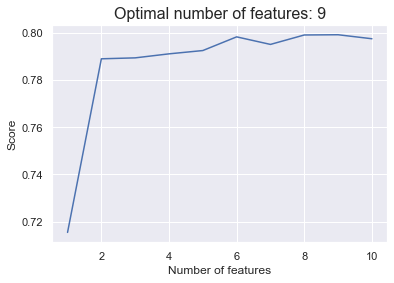

In [12]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

svc = SVC(kernel='linear')
min_features = 1
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(5),
              scoring='accuracy', min_features_to_select=min_features).fit(X, y)

optimal_features = rfecv.n_features_
plt.title(f'Optimal number of features: {optimal_features}', fontsize=16)
plt.plot(range(min_features, len(rfecv.grid_scores_) + min_features), rfecv.grid_scores_)
plt.xlabel('Number of features')
plt.ylabel('Score')
plt.show()
